In [76]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 12.0 MB/s eta 0:00:00
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.5.10 has a non-standard dependency specifier torch>=1.7.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader
import model
import tqdm
import seaborn as sbn
device = "cpu"

In [2]:
# functions
def train_sae(model, dataloader, epochs=10, lr=1e-3, l1_weight=1e-3, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in tqdm.tqdm(range(epochs)):
        total_loss = 0.0
        for batch in dataloader:
            # batch shape: [B, 370, 320]
            batch = batch.to(device)
            inputs = batch.view(-1, 320)  # [B*370, 320]

            z, recons = model(inputs)
            recon_loss = loss_fn(recons[-1], inputs)
            sparsity = l1_weight * torch.mean(torch.abs(z))
            loss = recon_loss + sparsity

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}: Loss = {total_loss:.4f}")

In [3]:
# load data
data_path = "data/model_outputs_8M_complete/"
master = False
df = None
if master:
    df = pd.read_csv(data_path + "master_attributes.csv")
else:
    df = pd.read_csv(data_path + "train.csv")

# try to load all data
seq_ids = list(df["Name"])
token_paths = list(df["Token Representations"])
token_reps = []

for path in token_paths:
    token_reps.append(torch.load("data/" + str(path)))
# token_reps = torch.stack(token_reps, dim=0)
# create splits
train_split_prop = 0.80
split_idx = int(len(token_reps) * train_split_prop)
train_token_reps = token_reps[:split_idx]
train_seq_ids = seq_ids[:split_idx]

test_token_reps = token_reps[split_idx:]
test_seq_ids = seq_ids[split_idx:]

# create datasets
train_dataset = model.TokenRepresentationDataset((train_seq_ids, train_token_reps))
test_dataset = model.TokenRepresentationDataset((test_seq_ids, test_token_reps))
# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, collate_fn=model.collate_token_batches)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True, collate_fn=model.collate_token_batches)

In [4]:
model_0 = model.MatryoshkaSAE(320, [64])

In [26]:
# train
train_sae(model_0, train_loader, epochs=100, lr=0.0001, l1_weight=0.01)

  1%|          | 1/100 [00:00<00:59,  1.68it/s]

Epoch 1: Loss = 0.1210


  2%|▏         | 2/100 [00:01<00:55,  1.77it/s]

Epoch 2: Loss = 0.1205


  3%|▎         | 3/100 [00:01<00:53,  1.81it/s]

Epoch 3: Loss = 0.1217


  4%|▍         | 4/100 [00:02<00:52,  1.83it/s]

Epoch 4: Loss = 0.1206


  5%|▌         | 5/100 [00:02<00:52,  1.82it/s]

Epoch 5: Loss = 0.1210


  6%|▌         | 6/100 [00:03<00:55,  1.69it/s]

Epoch 6: Loss = 0.1192


  7%|▋         | 7/100 [00:03<00:53,  1.74it/s]

Epoch 7: Loss = 0.1206


  8%|▊         | 8/100 [00:04<00:51,  1.79it/s]

Epoch 8: Loss = 0.1206


  9%|▉         | 9/100 [00:05<00:50,  1.80it/s]

Epoch 9: Loss = 0.1193


 10%|█         | 10/100 [00:05<00:49,  1.80it/s]

Epoch 10: Loss = 0.1178


 11%|█         | 11/100 [00:06<00:48,  1.83it/s]

Epoch 11: Loss = 0.1183


 12%|█▏        | 12/100 [00:06<00:47,  1.84it/s]

Epoch 12: Loss = 0.1197


 13%|█▎        | 13/100 [00:07<00:48,  1.79it/s]

Epoch 13: Loss = 0.1188


 14%|█▍        | 14/100 [00:07<00:48,  1.79it/s]

Epoch 14: Loss = 0.1178


 15%|█▌        | 15/100 [00:08<00:46,  1.81it/s]

Epoch 15: Loss = 0.1194


 16%|█▌        | 16/100 [00:08<00:45,  1.83it/s]

Epoch 16: Loss = 0.1193


 17%|█▋        | 17/100 [00:09<00:44,  1.85it/s]

Epoch 17: Loss = 0.1199


 18%|█▊        | 18/100 [00:09<00:44,  1.86it/s]

Epoch 18: Loss = 0.1190


 19%|█▉        | 19/100 [00:10<00:43,  1.85it/s]

Epoch 19: Loss = 0.1216


 20%|██        | 20/100 [00:11<00:43,  1.85it/s]

Epoch 20: Loss = 0.1190


 21%|██        | 21/100 [00:11<00:43,  1.82it/s]

Epoch 21: Loss = 0.1182


 22%|██▏       | 22/100 [00:12<00:42,  1.82it/s]

Epoch 22: Loss = 0.1205


 23%|██▎       | 23/100 [00:12<00:41,  1.85it/s]

Epoch 23: Loss = 0.1182


 24%|██▍       | 24/100 [00:13<00:41,  1.84it/s]

Epoch 24: Loss = 0.1206


 25%|██▌       | 25/100 [00:13<00:40,  1.83it/s]

Epoch 25: Loss = 0.1192


 26%|██▌       | 26/100 [00:14<00:40,  1.83it/s]

Epoch 26: Loss = 0.1200


 27%|██▋       | 27/100 [00:14<00:39,  1.84it/s]

Epoch 27: Loss = 0.1198


 28%|██▊       | 28/100 [00:15<00:38,  1.85it/s]

Epoch 28: Loss = 0.1203


 29%|██▉       | 29/100 [00:15<00:38,  1.84it/s]

Epoch 29: Loss = 0.1201


 30%|███       | 30/100 [00:16<00:38,  1.83it/s]

Epoch 30: Loss = 0.1179


 31%|███       | 31/100 [00:17<00:40,  1.72it/s]

Epoch 31: Loss = 0.1217


 32%|███▏      | 32/100 [00:17<00:38,  1.77it/s]

Epoch 32: Loss = 0.1188


 33%|███▎      | 33/100 [00:18<00:37,  1.79it/s]

Epoch 33: Loss = 0.1189


 34%|███▍      | 34/100 [00:18<00:36,  1.79it/s]

Epoch 34: Loss = 0.1196


 35%|███▌      | 35/100 [00:19<00:36,  1.79it/s]

Epoch 35: Loss = 0.1193


 36%|███▌      | 36/100 [00:19<00:35,  1.79it/s]

Epoch 36: Loss = 0.1177


 37%|███▋      | 37/100 [00:20<00:34,  1.81it/s]

Epoch 37: Loss = 0.1196


 38%|███▊      | 38/100 [00:21<00:34,  1.79it/s]

Epoch 38: Loss = 0.1183


 39%|███▉      | 39/100 [00:21<00:33,  1.81it/s]

Epoch 39: Loss = 0.1164


 40%|████      | 40/100 [00:22<00:32,  1.83it/s]

Epoch 40: Loss = 0.1182


 41%|████      | 41/100 [00:22<00:31,  1.85it/s]

Epoch 41: Loss = 0.1189


 42%|████▏     | 42/100 [00:23<00:31,  1.86it/s]

Epoch 42: Loss = 0.1211


 43%|████▎     | 43/100 [00:23<00:31,  1.84it/s]

Epoch 43: Loss = 0.1191


 44%|████▍     | 44/100 [00:24<00:30,  1.84it/s]

Epoch 44: Loss = 0.1180


 45%|████▌     | 45/100 [00:24<00:29,  1.86it/s]

Epoch 45: Loss = 0.1202


 46%|████▌     | 46/100 [00:25<00:29,  1.83it/s]

Epoch 46: Loss = 0.1207


 47%|████▋     | 47/100 [00:25<00:29,  1.81it/s]

Epoch 47: Loss = 0.1171


 48%|████▊     | 48/100 [00:26<00:28,  1.82it/s]

Epoch 48: Loss = 0.1177


 49%|████▉     | 49/100 [00:26<00:27,  1.83it/s]

Epoch 49: Loss = 0.1195


 49%|████▉     | 49/100 [00:27<00:28,  1.78it/s]


KeyboardInterrupt: 

In [27]:
# import notebook
df = pd.read_csv(data_path + "master_attributes.csv", index_col=0)
print(df.columns)
df.head()

Index(['Name', 'Sequence', 'Token Representations', 'ID', 'Description',
       'Length', 'Num_Features', 'Molecular Weight', 'Aromaticity',
       'Instability Index', 'Flexibility', 'GRAVY', 'Isoelectric Point',
       'Charge at pH:7.0'],
      dtype='object')


,Name,Sequence,Token Representations,ID,Description,Length,Num_Features,Molecular Weight,Aromaticity,Instability Index,Flexibility,GRAVY,Isoelectric Point,Charge at pH:7.0
0,UniRef50_A0A6A0B958,MNISKKRIVSISAAVLTLFGLVGSAQVFAENTKSDADTSNRNYKSY...,model_outputs_8M_complete/sample_output/token_...,UniRef50_A0A6A0B958,UniRef50_A0A6A0B958 Amidase n=1 Tax=Lactococcu...,443,0,46610.6242,0.085779,25.159842,"[1.0269404761904763, 1.0079761904761906, 0.995...",-0.400451,4.882776,-12.147103
1,UniRef50_A0A916QY52,MISKAGELLNFDYWWMIQNIYSIDGFSTNIFDWMFRANEHFVLIPA...,model_outputs_8M_complete/sample_output/token_...,UniRef50_A0A916QY52,UniRef50_A0A916QY52 Glycosyltransferase RgtA/B...,430,0,48708.5521,0.144186,40.467907,"[1.0262738095238095, 1.031607142857143, 0.9833...",0.774186,9.592589,13.076535
2,UniRef50_A0A7X6PT85,MAKMDLVDIFKKRTRHPMRPRSSEYITRLFPGFKKIDTGGGSLVAG...,model_outputs_8M_complete/sample_output/token_...,UniRef50_A0A7X6PT85,UniRef50_A0A7X6PT85 acetyl-CoA carboxytransfer...,406,0,45542.6412,0.086207,26.527611,"[0.9726309523809527, 0.9866904761904761, 1.011...",-0.333990,8.672432,5.365431
3,UniRef50_UPI000E1DF927,MKKITLLLLCFTTTYLTSQTEFGAKSLISGTGTQPYRIDSGFIDED...,model_outputs_8M_complete/sample_output/token_...,UniRef50_UPI000E1DF927,UniRef50_UPI000E1DF927 VCBS repeat-containing ...,466,0,50240.7217,0.094421,24.257103,"[0.9683690476190479, 0.9641309523809524, 0.946...",-0.064592,4.050028,-47.178216
4,UniRef50_A0A9W6ZLJ6,MESSGEERKKIAVVGSGIAGLSCAWLLSQKHDVTIFEREKKLGMDA...,model_outputs_8M_complete/sample_output/token_...,UniRef50_A0A9W6ZLJ6,UniRef50_A0A9W6ZLJ6 Uncharacterized protein (F...,380,0,42390.0028,0.113158,31.412105,"[1.067309523809524, 1.0653452380952382, 1.0441...",-0.183684,6.264646,-2.885393


In [41]:
train_df = pd.DataFrame(train_seq_ids, columns=["Name"])
train_df = pd.merge(train_df, df, how="left", on="Name")
train_df.columns

Index(['Name', 'Sequence', 'Token Representations', 'ID', 'Description',
       'Length', 'Num_Features', 'Molecular Weight', 'Aromaticity',
       'Instability Index', 'Flexibility', 'GRAVY', 'Isoelectric Point',
       'Charge at pH:7.0'],
      dtype='object')

In [29]:
train_no_shuffle_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=model.collate_token_batches)
assert len(train_seq_ids) == len(train_dataset)
print(train_seq_ids) # should keep same order as df above

['UniRef50_A0A6A0B958', 'UniRef50_A0A916QY52', 'UniRef50_A0A7X6PT85', 'UniRef50_UPI000E1DF927', 'UniRef50_A0A9W6ZLJ6', 'UniRef50_A0A4V6E9C0', 'UniRef50_UPI001F3BA687', 'UniRef50_A0A4W5Q0X8', 'UniRef50_A0A2E0V9T8', 'UniRef50_A0A1V1P4G8', 'UniRef50_Q5B4E8', 'UniRef50_A0A6G1GYP2', 'UniRef50_A0A7V4UGV3', 'UniRef50_A0A254NSX8', 'UniRef50_UPI003618257D', 'UniRef50_A0A7Y1UZ22', 'UniRef50_A0A2N2AB41', 'UniRef50_A0A8T6YB83', 'UniRef50_A0A6J4XJY1', 'UniRef50_A0A8J7ZAC0', 'UniRef50_UPI000817D4F4', 'UniRef50_A0A3M9ZNR7', 'UniRef50_A0A1B8G8A0', 'UniRef50_A0A0L0DDZ4', 'UniRef50_A0A7J6NKQ1', 'UniRef50_A0A1X1BJU6', 'UniRef50_A0A1X7TDF2', 'UniRef50_UPI000E9B0B35', 'UniRef50_B7G7Z2', 'UniRef50_UPI00230808D1', 'UniRef50_X6M6X6', 'UniRef50_A0AAF0XUS6', 'UniRef50_A0A152A9G5', 'UniRef50_A0A353X534', 'UniRef50_A0A1Z5RHA3', 'UniRef50_A0AAE1FM87', 'UniRef50_A0A372QM76', 'UniRef50_A0A3M1C372', 'UniRef50_A0A7K1ZMN9', 'UniRef50_A0A9P4ICN2', 'UniRef50_A0A654AP00', 'UniRef50_A0A1I3TX22', 'UniRef50_A0A9P6AVX7', 'Uni

In [30]:
# collect sample results
assert len(train_seq_ids) == len(train_no_shuffle_loader), "Mismatch in number of sequences and samples"
latent_codes = []
model_0.eval()
for seq, sample in zip(train_seq_ids, train_no_shuffle_loader):
    z, recon = model_0(sample)
    latent_codes.append(z)
print("shape of latent codes is: " + str(latent_codes[0].shape))

shape of latent codes is: torch.Size([445, 64])


In [31]:
Z = torch.cat(latent_codes, dim=0)  # shape: [total_tokens, latent_dim]

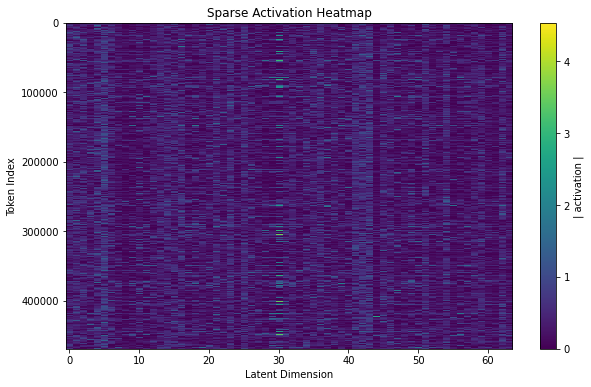

In [33]:
# Plot heatmap of latent activations
plt.figure(figsize=(10, 6))
plt.imshow(Z.detach().cpu().abs().numpy(), aspect='auto', interpolation='none', )
plt.colorbar(label="| activation |")
plt.xlabel("Latent Dimension")
plt.ylabel("Token Index")
plt.title("Sparse Activation Heatmap")
plt.show()


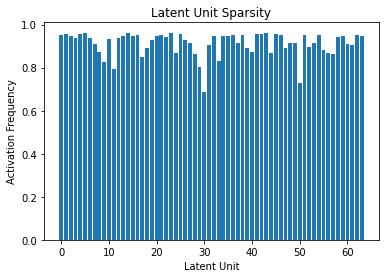

In [42]:
sparsity = (Z.abs() > 1e-4).float().mean(dim=0)  # mean activity per unit
plt.bar(range(len(sparsity)), sparsity)
plt.xlabel("Latent Unit")
plt.ylabel("Activation Frequency")
plt.title("Latent Unit Sparsity")
plt.show()


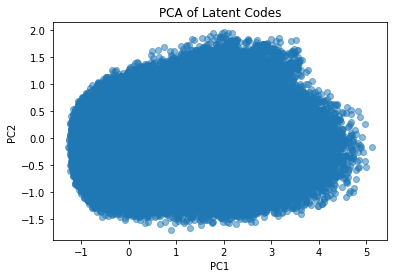

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
Z_pca = pca.fit_transform(Z.detach().cpu().numpy())

plt.scatter(Z_pca[:, 0], Z_pca[:, 1], alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Latent Codes")
plt.show()


In [78]:
from scipy.stats import spearmanr

# Step 1: mean-pool each latent code (z: [370, latent_dim]) → [latent_dim]
Z_mean = torch.stack([z.mean(dim=0).detach() for z in latent_codes])  # shape: [N, latent_dim]

# Step 2: correlate with each numerical feature
results = []
for feature in ['Molecular Weight', 'Aromaticity', 'Instability Index','GRAVY', 'Isoelectric Point', 'Charge at pH:7.0']:
    y = torch.tensor(train_df[feature].to_numpy(), dtype=torch.float32)
    for i in range(Z_mean.shape[1]):
        r, p = spearmanr(Z_mean[:, i], y)
        results.append((feature, i, r, p))

df_corr = pd.DataFrame(results, columns=["Feature", "Latent Unit", "Spearman r", "p-value"])

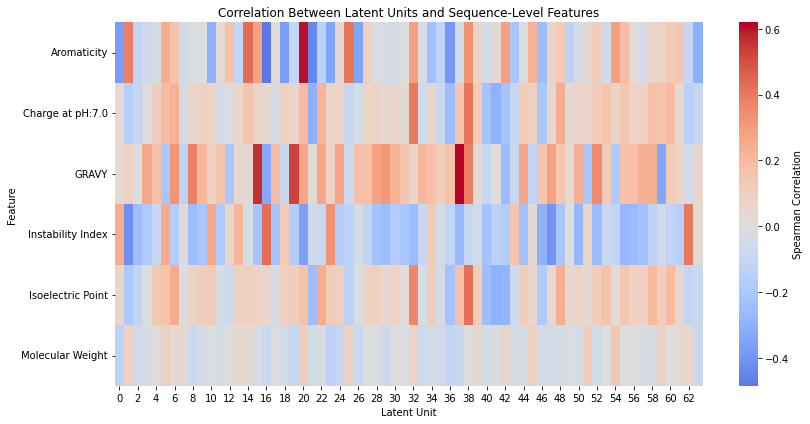

In [79]:
import seaborn as sns

# Pivot the correlation DataFrame
heatmap_data = df_corr.pivot(index="Feature", columns="Latent Unit", values="Spearman r")

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", center=0, annot=False, cbar_kws={"label": "Spearman Correlation"})
plt.title("Correlation Between Latent Units and Sequence-Level Features")
plt.xlabel("Latent Unit")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [73]:
top_charge = df_corr[df_corr["Feature"] == "GRAVY"].sort_values("Spearman r", ascending=False).head(10)
print(top_charge)

    Feature  Latent Unit  Spearman r        p-value
229   GRAVY           37    0.619215  5.897761e-128
207   GRAVY           15    0.564667  5.285849e-102
211   GRAVY           19    0.525575   3.485574e-86
230   GRAVY           38    0.387298   3.122442e-44
200   GRAVY            8    0.378244   4.144328e-42
244   GRAVY           52    0.352728   1.773003e-36
198   GRAVY            6    0.323724   1.123041e-30
221   GRAVY           29    0.309784   4.196037e-28
239   GRAVY           47    0.281321   2.890006e-23
220   GRAVY           28    0.280880   3.401109e-23


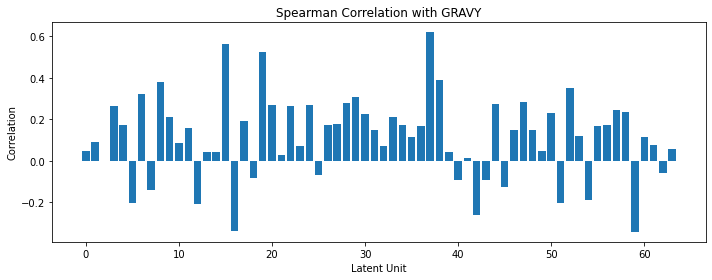

In [80]:
feature_name = "GRAVY"
subset = df_corr[df_corr["Feature"] == feature_name].sort_values("Spearman r", ascending=False)

plt.figure(figsize=(10, 4))
plt.bar(subset["Latent Unit"], subset["Spearman r"])
plt.title(f"Spearman Correlation with {feature_name}")
plt.xlabel("Latent Unit")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()


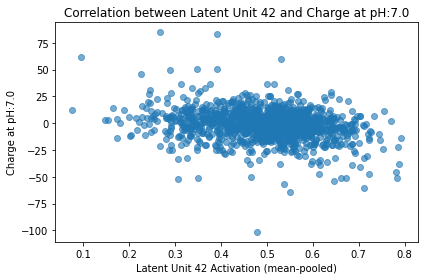

In [81]:
unit_index = 42
feature_name = "Charge at pH:7.0"

x = Z_mean[:, unit_index].detach().cpu().numpy()
y = train_df[feature_name].values

plt.figure(figsize=(6, 4))
plt.scatter(x, y, alpha=0.6)
plt.xlabel(f"Latent Unit {unit_index} Activation (mean-pooled)")
plt.ylabel(feature_name)
plt.title(f"Correlation between Latent Unit {unit_index} and {feature_name}")
plt.tight_layout()
plt.show()


In [83]:
# Get mean z for two samples
z1 = latent_codes[0].mean(dim=0)
z2 = latent_codes[1].mean(dim=0)

alphas = torch.linspace(0, 1, steps=10)
interpolations = [(1 - a) * z1 + a * z2 for a in alphas]

# Decode and visualize differences
for i, z_interp in enumerate(interpolations):
    z_interp_expanded = z_interp.unsqueeze(0).repeat(370, 1)  # to match input shape
    recon = model_0.decode(z_interp_expanded)[-1]  # shape [370, 320]
    # Visualize or project recon here


AttributeError: 'MatryoshkaSAE' object has no attribute 'decode'

In [84]:
# Grab one [370, 320] sequence
sample = next(iter(train_no_shuffle_loader))[1]

model_0.eval()
with torch.no_grad():
    z, recons = model_0(sample)  # z: [370, latent_dim]
    base_recon = recons[-1]      # shape [370, 320]
    base_error = torch.nn.functional.mse_loss(base_recon, sample).item()

# Ablate each unit: zero one dimension across all tokens
delta_errors = []
for i in range(z.shape[1]):
    z_ablate = z.clone()
    z_ablate[:, i] = 0.0  # zero out unit i for all tokens
    # Get reconstruction from ablated z
    recon_ablate = model_0.decode(z_ablate)[-1]  # shape [370, 320]
    error = torch.nn.functional.mse_loss(recon_ablate, sample).item()
    delta_errors.append(error - base_error)

# Plot
plt.figure(figsize=(10, 4))
plt.bar(range(len(delta_errors)), delta_errors)
plt.xlabel("Latent Unit")
plt.ylabel("Δ Reconstruction Error")
plt.title("Latent Unit Importance via Ablation")
plt.tight_layout()
plt.show()


IndexError: too many indices for tensor of dimension 1

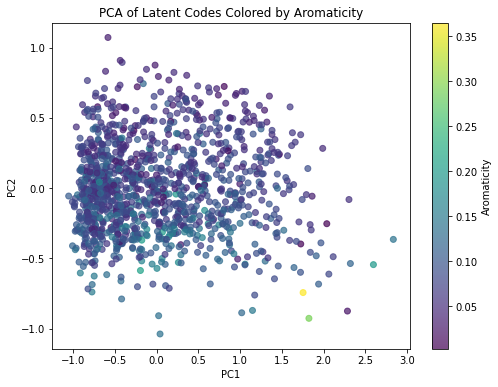

In [87]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Z_np = Z_mean.detach().cpu().numpy()
pca = PCA(n_components=2)
Z_pca = pca.fit_transform(Z_np)

plt.figure(figsize=(8,6))
plt.scatter(Z_pca[:, 0], Z_pca[:, 1], c=train_df['Aromaticity'], cmap='viridis', alpha=0.7)
plt.colorbar(label="Aromaticity")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Latent Codes Colored by Aromaticity")
plt.show()


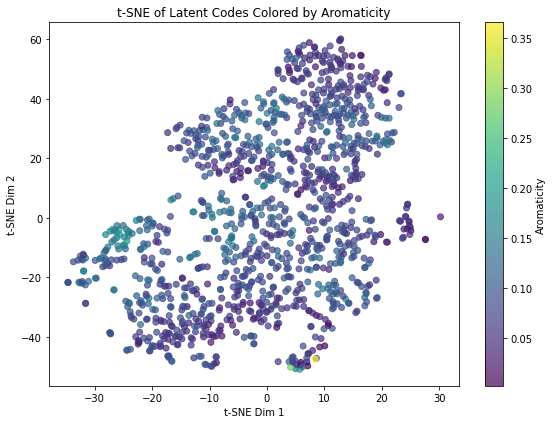

In [88]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Convert latent vectors to numpy
Z_np = Z_mean.detach().cpu().numpy()  # shape: [N, latent_dim]

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='random', random_state=42)
Z_tsne = tsne.fit_transform(Z_np)

# Plot, colored by Aromaticity
plt.figure(figsize=(8, 6))
plt.scatter(Z_tsne[:, 0], Z_tsne[:, 1], c=train_df['Aromaticity'], cmap='viridis', alpha=0.7)
plt.colorbar(label="Aromaticity")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("t-SNE of Latent Codes Colored by Aromaticity")
plt.tight_layout()
plt.show()


/Users/davidm/opt/anaconda3/envs/esmfold/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


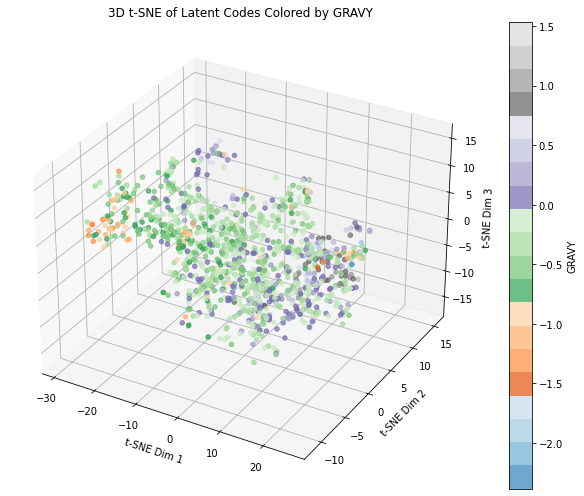

In [102]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed to register the 3D projection

# Compute 3D t-SNE
Z_np = Z_mean.detach().cpu().numpy()
tsne = TSNE(n_components=3, perplexity=20, learning_rate='auto', init='pca', random_state=42)
Z_tsne_3d = tsne.fit_transform(Z_np)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(Z_tsne_3d[:, 0], Z_tsne_3d[:, 1], Z_tsne_3d[:, 2],
               c=train_df['GRAVY'], cmap='tab20c', alpha=0.7)
fig.colorbar(p, label="GRAVY")

ax.set_xlabel("t-SNE Dim 1")
ax.set_ylabel("t-SNE Dim 2")
ax.set_zlabel("t-SNE Dim 3")
ax.set_title("3D t-SNE of Latent Codes Colored by GRAVY")

plt.tight_layout()
plt.show()


In [94]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Flatten each z ∈ [370, latent_dim] → [370 × latent_dim]
z_flat_list = [z.view(-1).detach().cpu().numpy() for z in latent_codes]  # shape [N, 370 * latent_dim]

# Step 2: Stack into array for t-SNE
Z_flat = np.stack(z_flat_list)  # shape [N, 370 * latent_dim]

# Step 3: Apply t-SNE in 2D or 3D
tsne = TSNE(n_components=3, perplexity=30, learning_rate='auto', init='random', random_state=42)
Z_tsne_3d = tsne.fit_transform(Z_flat)

# Step 4: Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(Z_tsne_3d[:, 0], Z_tsne_3d[:, 1], Z_tsne_3d[:, 2],
               c=train_df['Aromaticity'], cmap='viridis', alpha=0.7)
fig.colorbar(p, label="Aromaticity")

ax.set_xlabel("t-SNE Dim 1")
ax.set_ylabel("t-SNE Dim 2")
ax.set_zlabel("t-SNE Dim 3")
ax.set_title("3D t-SNE of Flattened Latent Codes")
plt.tight_layout()
plt.show()


ValueError: all input arrays must have the same shape